The RDKit's code for doing R-group decomposition is quite flexible but also rather "undocumented". Thanks to that fact, you may not be aware of some of the cool stuff that's there. This post is an attempt to at least begin to remedy that.

We'll look at three difficult problems that arise all the time when doing R-group decomposition on real-world datasets:

    - Handling symmetric cores
    - Handling stereochemistry
    - Handling sidechains that attach to the core at more than one point
    

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import rdRGroupDecomposition
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
import rdkit


In [9]:
def groups_to_df(groups,mols,include_core=False,redraw_sidechains=False):
    """ add the molecule to the dataframe 
    """
    cols = ['Mol']+list(groups.keys())
    if redraw_sidechains:
        for k,vl in groups.items():
            if k=='Core':
                continue
            for i,v in enumerate(vl):
                vl[i] = Chem.RemoveHs(v)
                rdDepictor.Compute2DCoords(vl[i])

    
    if not include_core:
        cols.remove('Core')
        del groups['Core']
    groups['Mol'] = mols
    frame = pd.DataFrame(groups,columns=cols)
    PandasTools.ChangeMoleculeRendering(frame)
    return frame

# Basics: a symmetric core

Let's start with an easy example that has a symmetric core. In this case R1 and R5 are symmetry equivalent as are R2 and R4):

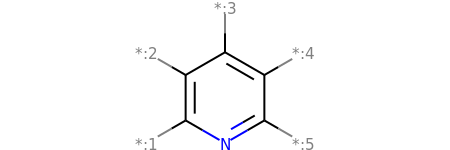

In [3]:
scaffold = Chem.MolFromSmiles('[*:1]c1c([*:2])c([*:3])c([*:4])c([*:5])n1')
scaffold

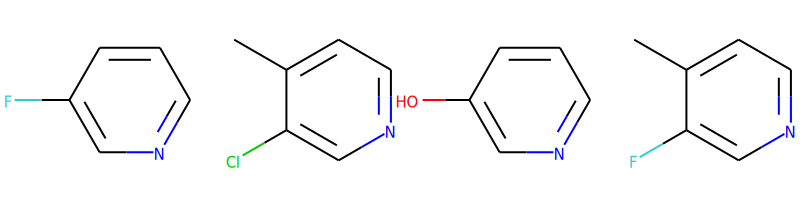

In [4]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(O)cccn1 c1c(F)c(C)ccn1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

Do a version w/o the R labels to start with:

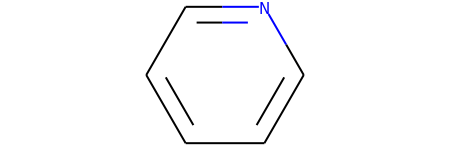

In [5]:
scaffold = Chem.MolFromSmiles('c1ccccn1')
scaffold

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,

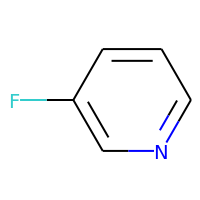
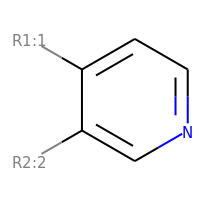
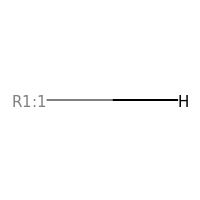
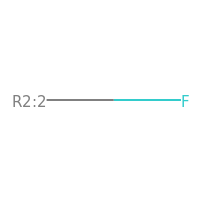
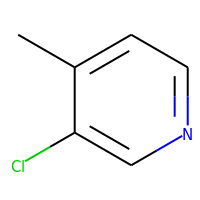
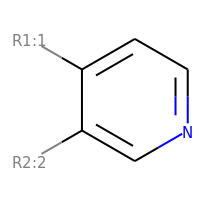
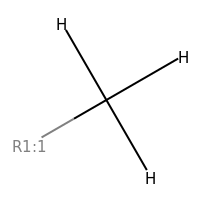
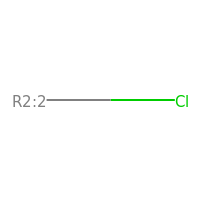
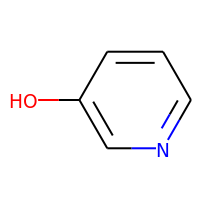
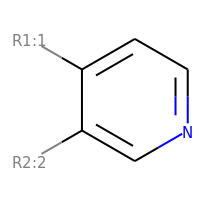
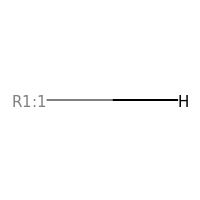
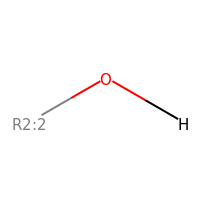
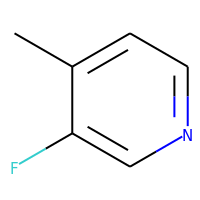
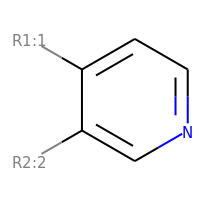
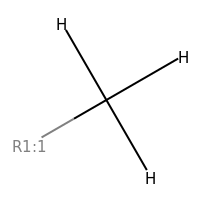
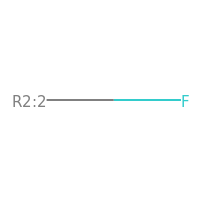

In [6]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
groups_to_df(groups,mols,include_core=True)

Those labels were automatically assigned and they aren't consistent with what we had above. We can go ahead and explicitly label the side chains:

,Mol,Core,R2,R3
0,,,,
1,,,,
2,,,,
3,,,,

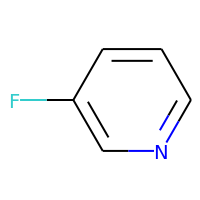
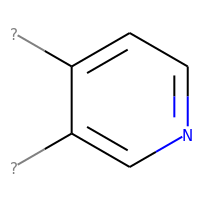
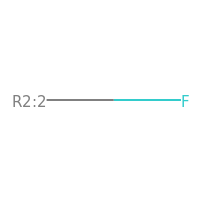
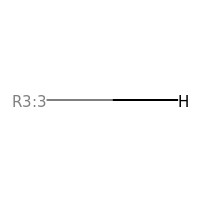
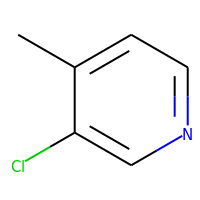
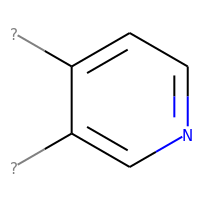
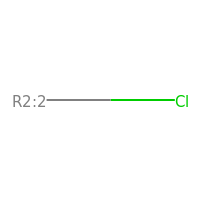
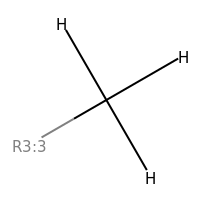
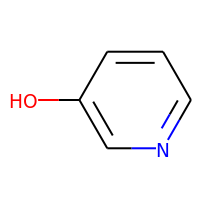
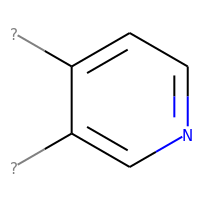
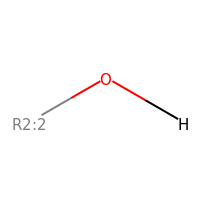
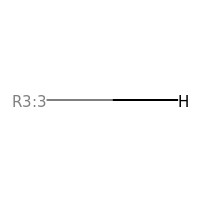
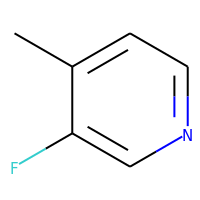
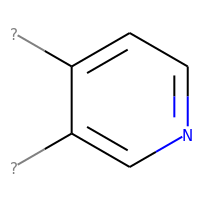
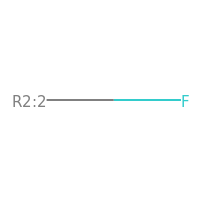
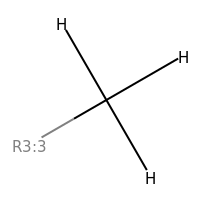

In [7]:
# note: there's a bug in RDKit 2019.03.3 and 2019.03.4 that causes this to generate different
# results with those versions
scaffold = Chem.MolFromSmiles('c1c([*:2])c([*:3])ccn1')
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
groups_to_df(groups,mols,include_core=True)

We've just been looking at compound images since that's a bit more readable. Here's what the raw output from the function:

In [8]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=True,asRows=False) 
print(groups)

{'Core': ['c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1', 'c1cc([*:3])c([*:2])cn1'], 'R2': ['F[*:2]', 'Cl[*:2]', '[H]O[*:2]', 'F[*:2]'], 'R3': ['[H][*:3]', '[H]C([H])([H])[*:3]', '[H][*:3]', '[H]C([H])([H])[*:3]']}


# Stereochemistry

Making sure that the sidechains are labelled correctly on chiral centers can be a bit trickier.

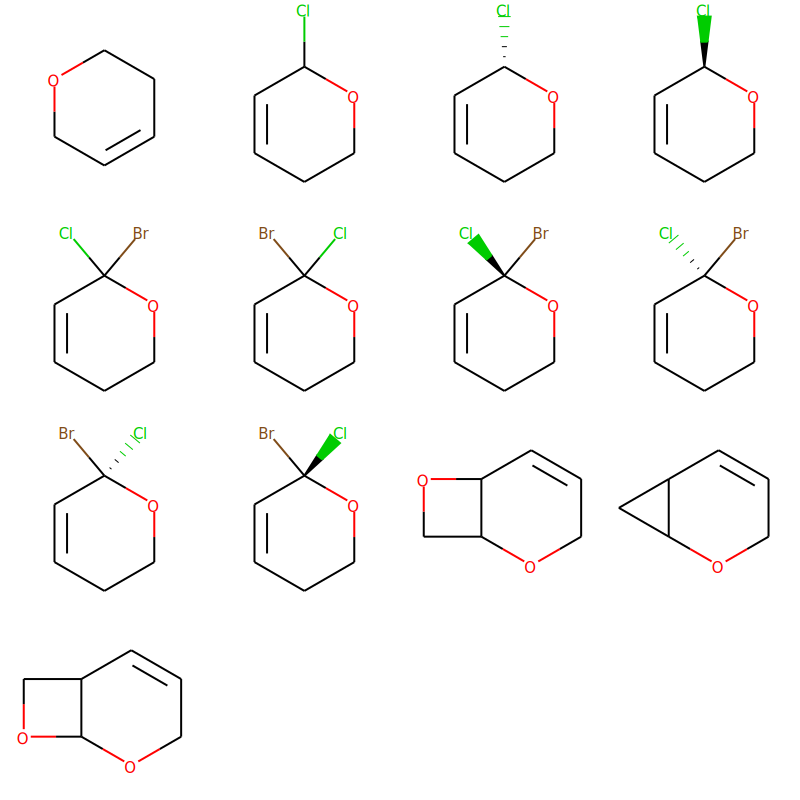

In [9]:
mols = [x for x in Chem.SDMolSupplier('../data/rgd_chiral.sdf')]
Draw.MolsToGridImage(mols,molsPerRow=4)

Remove the examples with "ring" sidechains. We'll get to those later

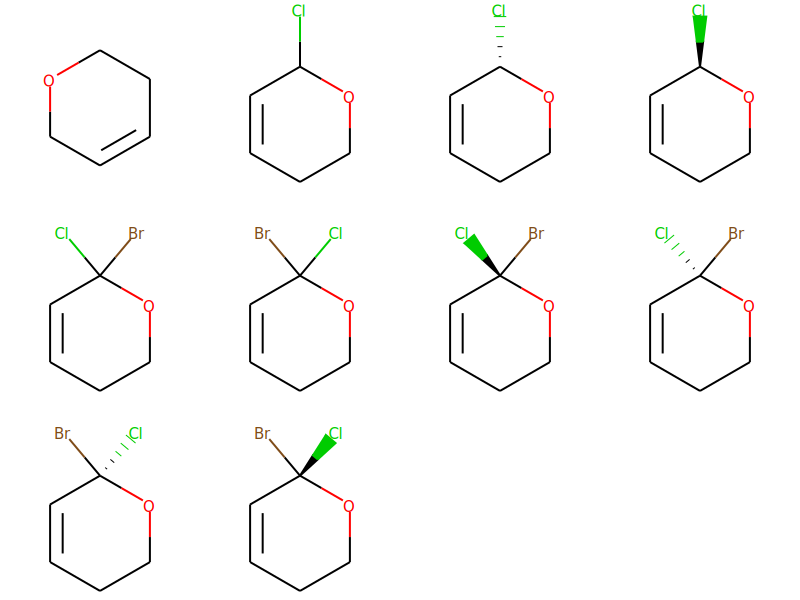

In [10]:
q = Chem.MolFromSmarts('[R2]')
mols = [x for x in mols if not x.HasSubstructMatch(q)]
Draw.MolsToGridImage(mols,molsPerRow=4)

In [11]:
!cat ../data/rgd_chiral.sdf


  Mrv1824 02281916362D          

  6  6  0  0  1  0            999 V2000
    0.0000    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145    0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145    0.4125    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  1  6  1  0  0  0  0
  2  3  1  0  0  0  0
  3  4  2  0  0  0  0
  4  5  1  0  0  0  0
  5  6  1  0  0  0  0
M  END
$$$$

  Mrv1824 02281916362D          

  7  7  0  0  1  0            999 V2000
    4.0291   -0.6482    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3147   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6002   -0.6482    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6002    0.1768    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.

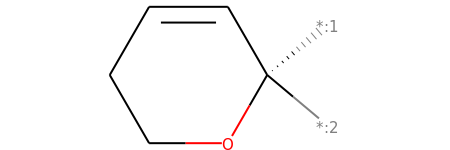

In [12]:
scaffold = Chem.MolFromSmiles('[*:1]C1([*:2])OCCC=C1')
chiral_scaffold = Chem.MolFromSmiles('[*:1][C@]1([*:2])OCCC=C1')
chiral_scaffold

Start with doing a decomposition with the non-chiral scaffold. This generates results that are not consistent with the chirality. The compounds in rows 2 and 3 (numbered from zero) demonstrate the problem clearly.

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,

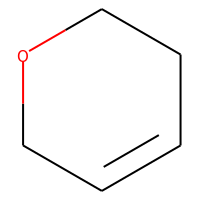
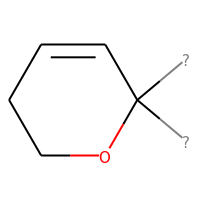
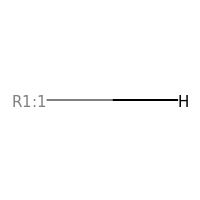
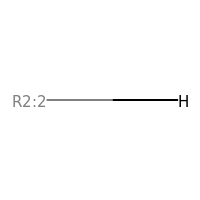
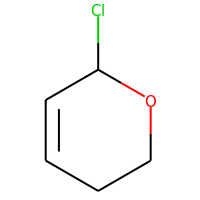
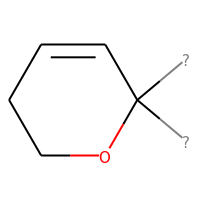
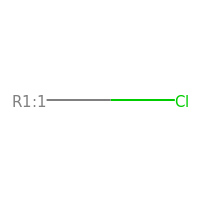
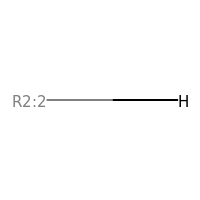
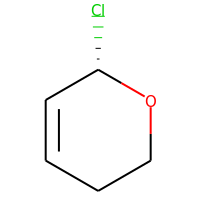
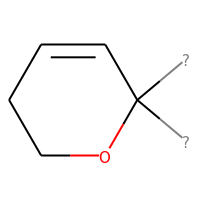
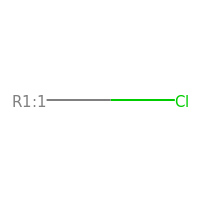
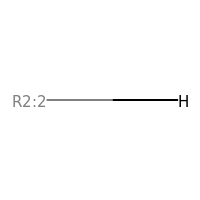
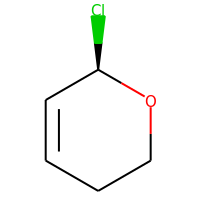
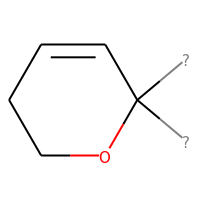
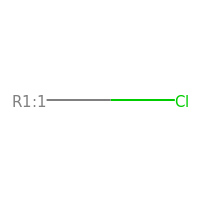
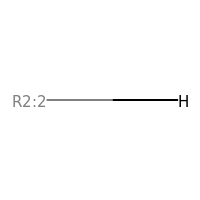
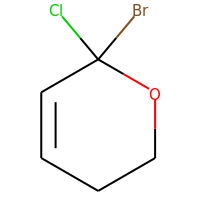
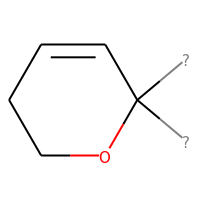
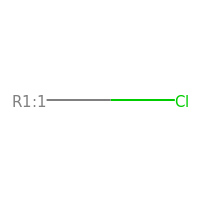
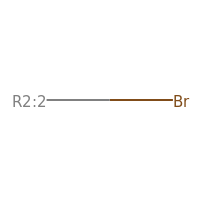
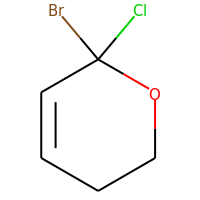
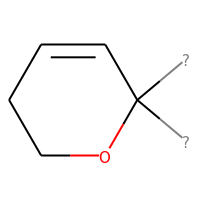
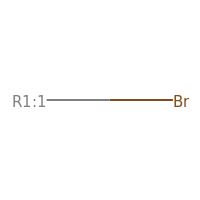
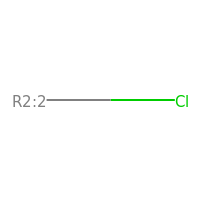
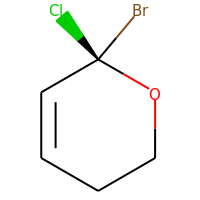
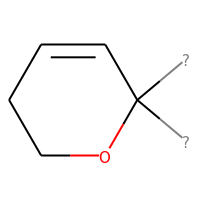
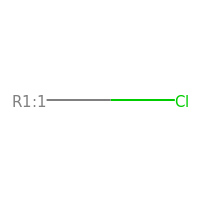
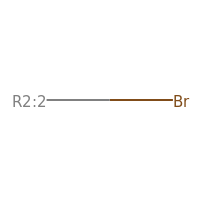
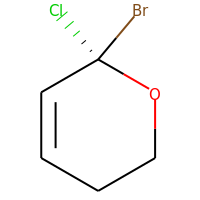
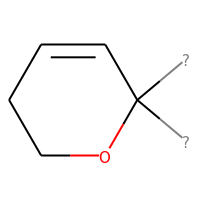
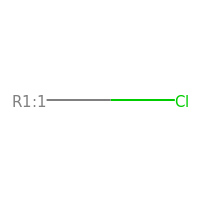
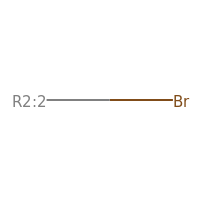
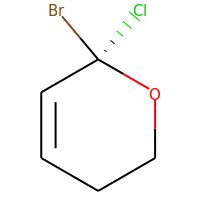
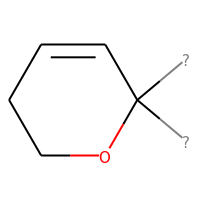
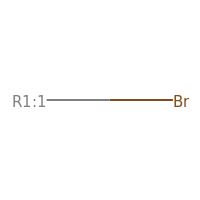
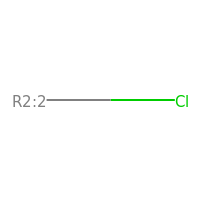
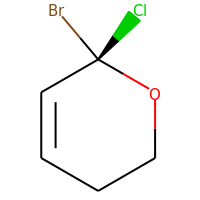
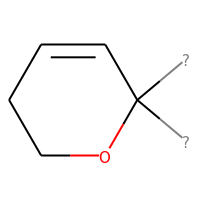
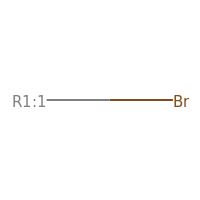
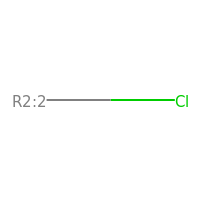

In [13]:
groups,_ = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
groups_to_df(groups,mols,include_core=True,redraw_sidechains=True)

Try the chiral scaffold. This one will only match the chiral compounds, but it does the right thing:

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,

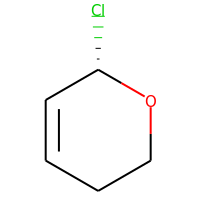
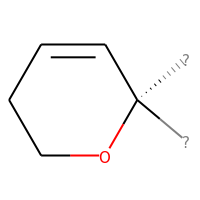
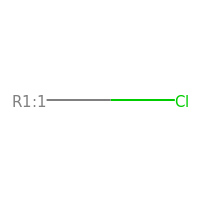
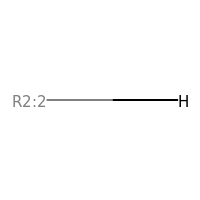
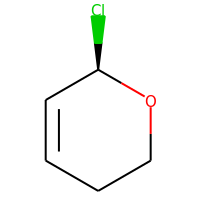
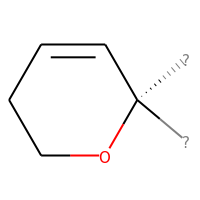
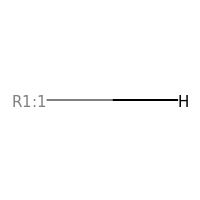
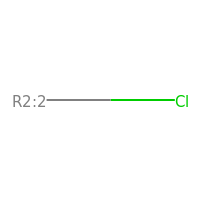
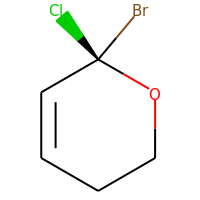
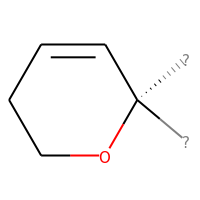
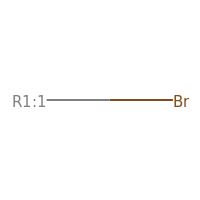
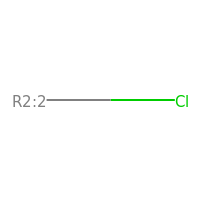
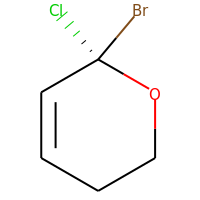
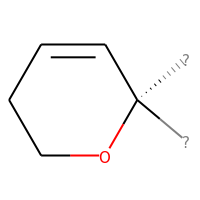
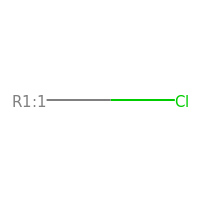
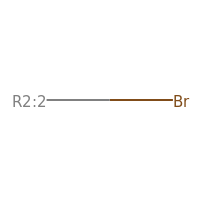
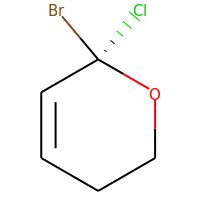
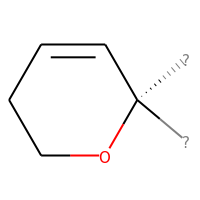
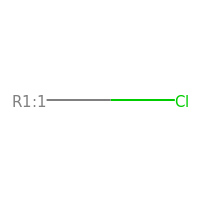
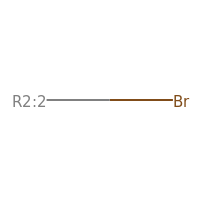
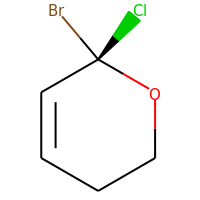
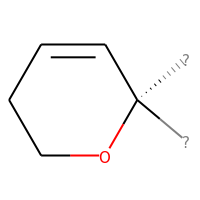
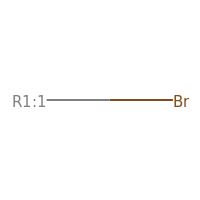
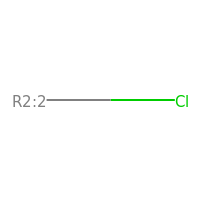

In [14]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([chiral_scaffold],mols,asSmiles=False,asRows=False)
tmols = [mols[x] for x in range(len(mols)) if x not in unmatched]
groups_to_df(groups,tmols,include_core=True,redraw_sidechains=True)

Note that in each case the atom is assigned to the correct R group.

We can also combine the two scaffolds so that we can get the chiral and achiral cases. Order is important, so we include the more specific scaffold (the chiral one) first:

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,

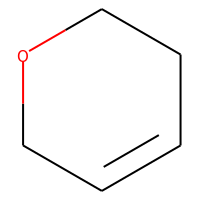
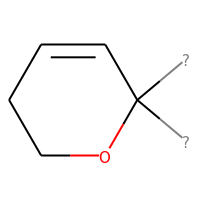
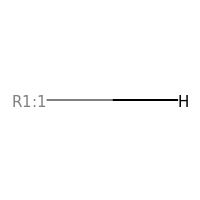
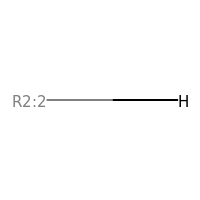
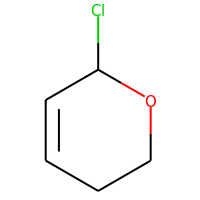
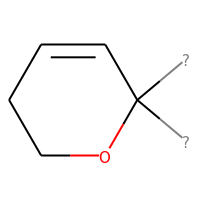
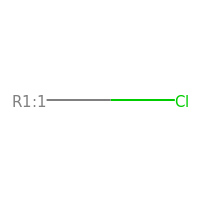
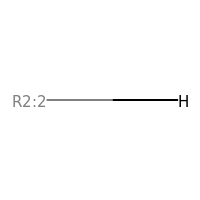
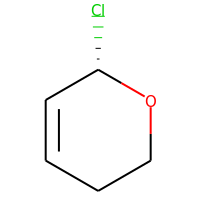
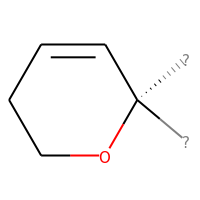
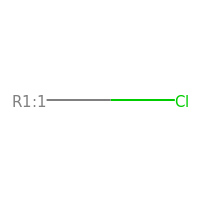
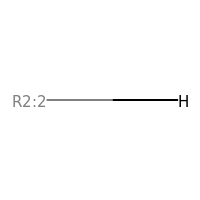
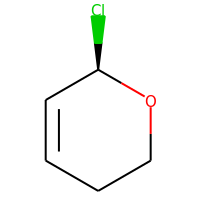
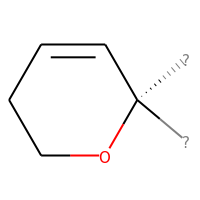
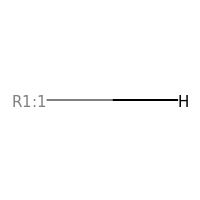
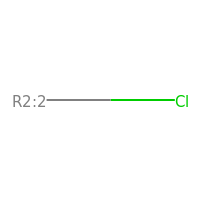
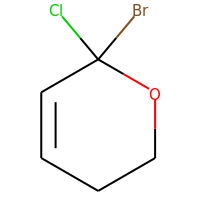
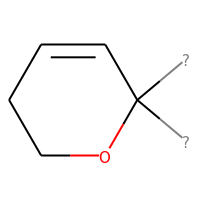
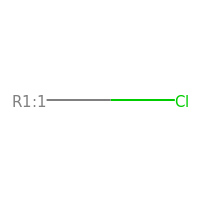
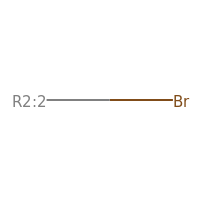
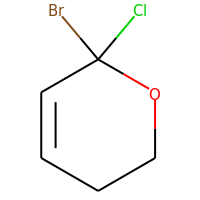
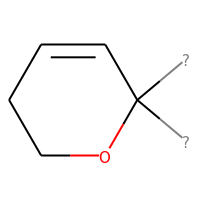
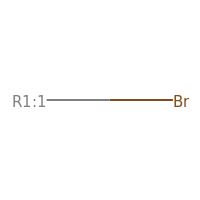
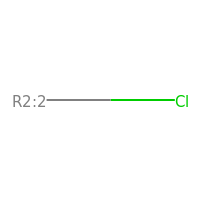
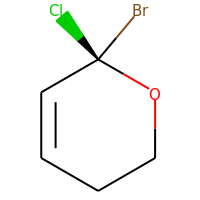
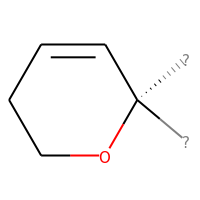
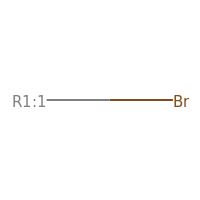
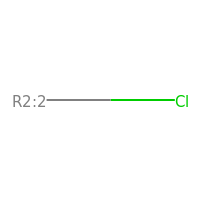
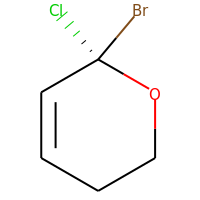
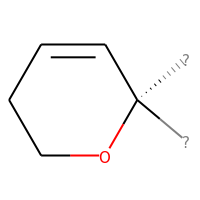
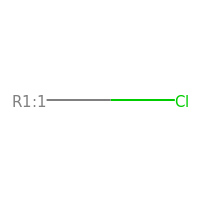
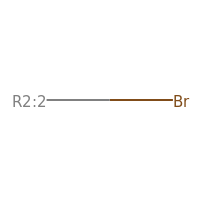
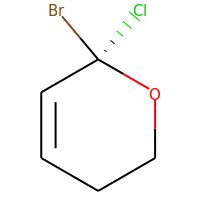
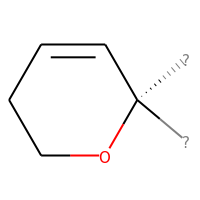
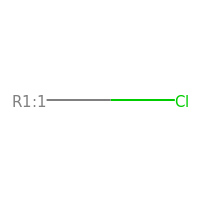
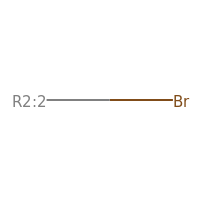
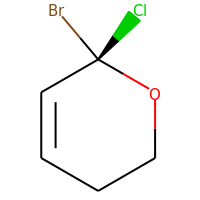
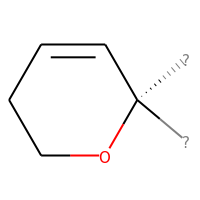
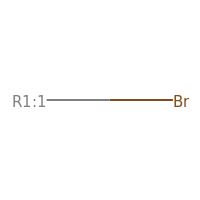
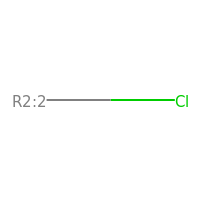

In [15]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([chiral_scaffold,scaffold],mols,asSmiles=False,asRows=False)
groups_to_df(groups,mols,include_core=True,redraw_sidechains=True)

# Sidechains that attach in more than one place

This one is tricky, and there's not really a right answer, this is just a demonstration of what the current code does

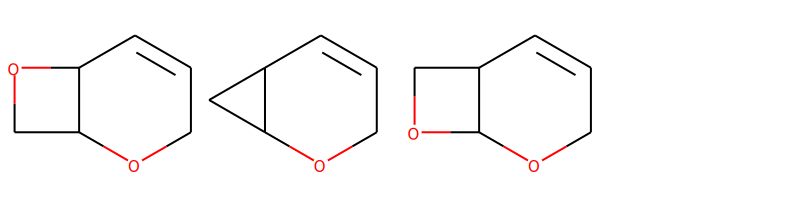

In [16]:
mols = [x for x in Chem.SDMolSupplier('../data/rgd_chiral.sdf')]
q = Chem.MolFromSmarts('[R2]')
mols = [x for x in mols if x.HasSubstructMatch(q)]
Draw.MolsToGridImage(mols,molsPerRow=4)

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,

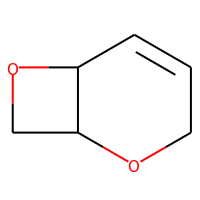
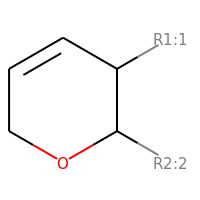
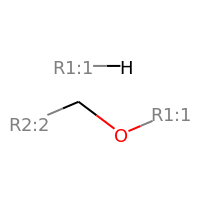
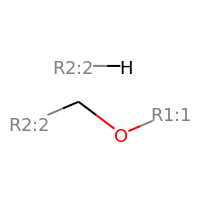
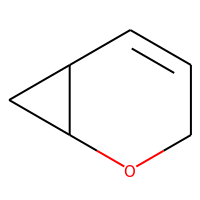
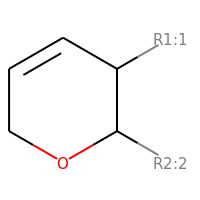
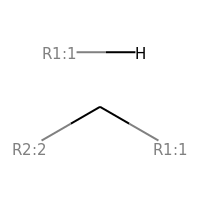
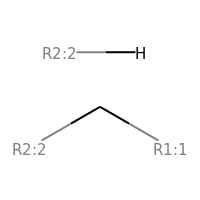
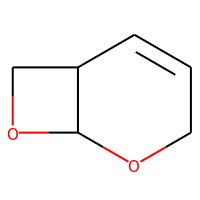
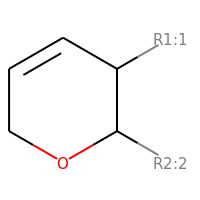
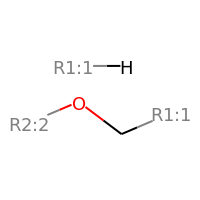
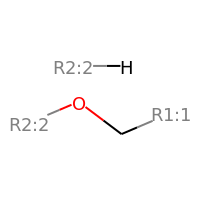

In [17]:
scaffold = Chem.MolFromSmiles('C1OCC=CC1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False)
groups_to_df(groups,mols,include_core=True,redraw_sidechains=True)

# Scaffold Variation

What happens if there are small variations in the scaffold within the series, something that we see all the time in med chem work?

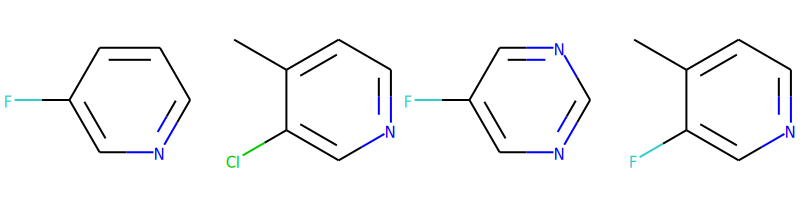

In [18]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(F)cncn1 c1c(F)c(C)ccn1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

In [19]:
scaffold = Chem.MolFromSmiles('c1c([*:1])c([*:2])ccn1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=True,asRows=False)
groups

{'Core': ['c1cc([*:2])c([*:1])cn1',
  'c1cc([*:2])c([*:1])cn1',
  'c1cc([*:2])c([*:1])cn1'],
 'R1': ['F[*:1]', 'Cl[*:1]', 'F[*:1]'],
 'R2': ['[H][*:2]', '[H]C([H])([H])[*:2]', '[H]C([H])([H])[*:2]']}

You can see that now we only get three results, the third molecule didn't end up in the output.
Sometimes this is ok, but in cases like this it would be great if that molecule were also included in the R-group decomposition. 

One solution to this is to provide two different scaffolds:

,Mol,Core,R1,R2,R3
0,,,,,
1,,,,,
2,,,,,
3,,,,,

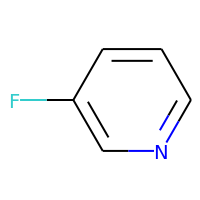
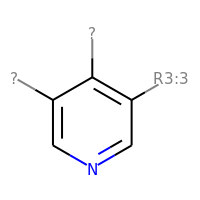
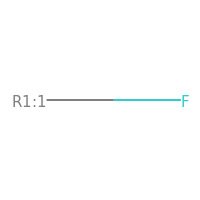
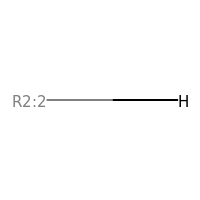
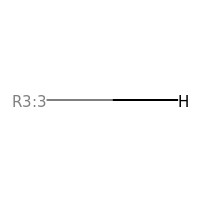
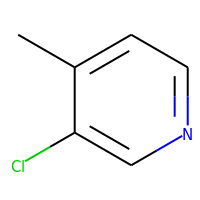
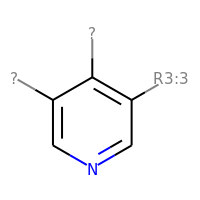
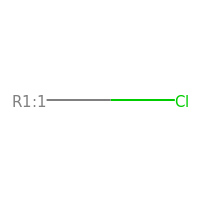
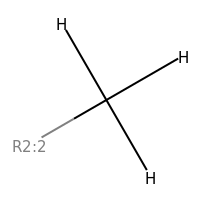
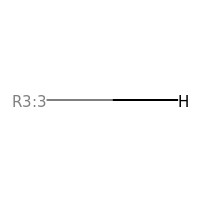
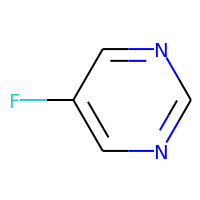
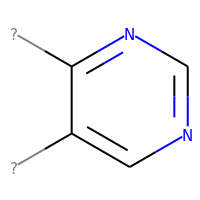
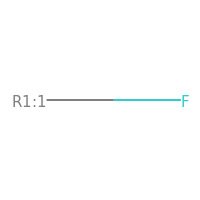
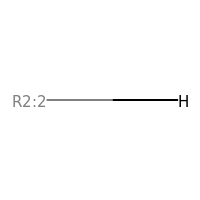
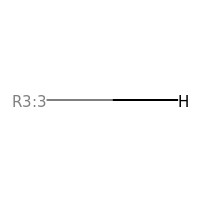
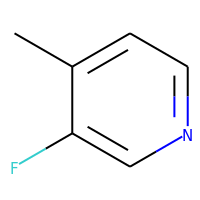
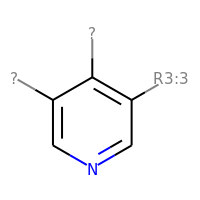
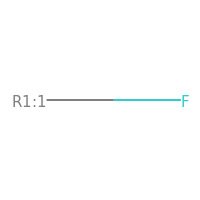
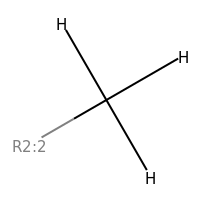
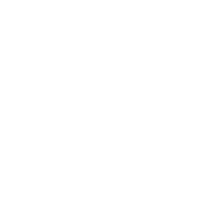

In [20]:
scaffold2 = Chem.MolFromSmiles('c1c([*:1])c([*:2])ncn1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold,scaffold2],mols,asSmiles=False,asRows=False)
groups_to_df(groups,mols,include_core=True)

Another is provide the scaffold as SMARTS and treat the variability point itself as one of the R groups:

,Mol,Core,R1,R2,R3
0,,,,,
1,,,,,
2,,,,,
3,,,,,

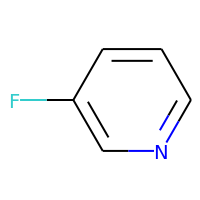
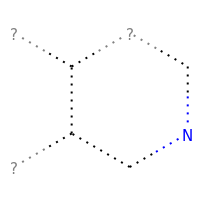
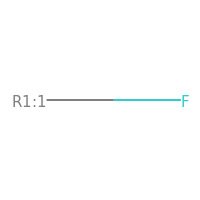
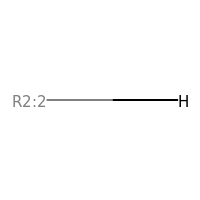
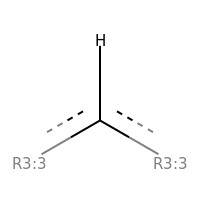
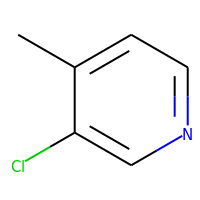
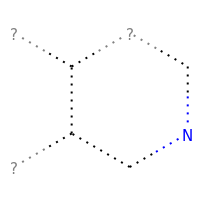
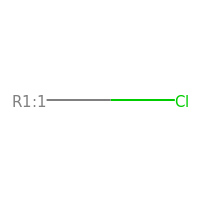
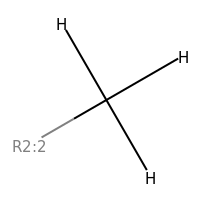
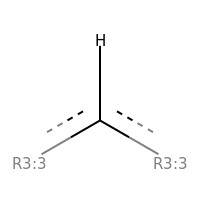
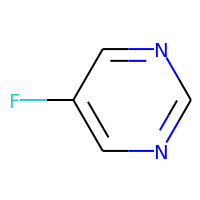
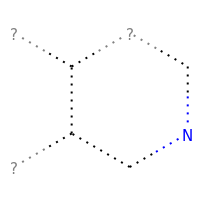
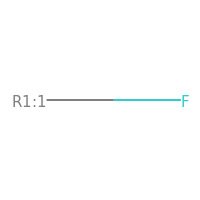
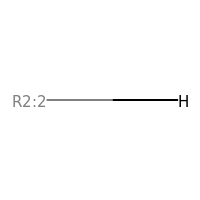
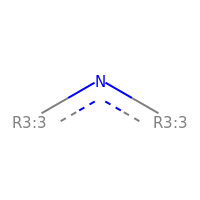
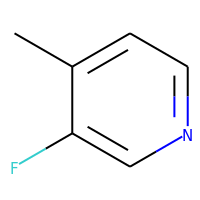
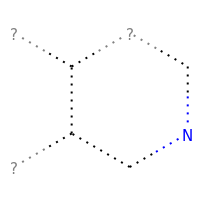
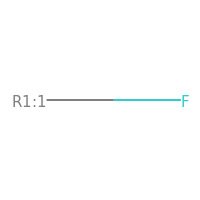
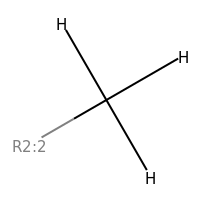
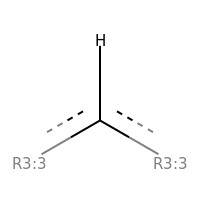

In [21]:
sma_scaffold = Chem.MolFromSmarts('c1c([*:1])c([*:2])*cn1')
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([sma_scaffold],mols,asSmiles=False,asRows=False)
groups_to_df(groups,mols,include_core=True)

# Looking at the options that are available

We'll use a real dataset pulled from ChEMBL for this:

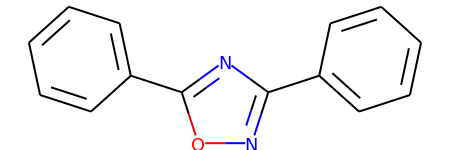

In [7]:
core = Chem.MolFromSmiles('c1ccccc1-c2nc(c1ccccc1)no2')
core

In [2]:
smiles = ['CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5ccccc5)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'CCOc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'CC(C)Cc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5ccc(F)cc5)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CCC5)cc4)n3)cc2)C1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4noc(-c5ccccc5)n4)cc3)cc2)C(=O)NC(=O)NC1=O', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc([C@@H]5CCC(F)(F)C5)cc4)n3)cc2)C1', 'CC(C)(C)c1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C(F)(F)F)c(C#N)c2)n1', 'Cc1cc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)ccc1OC(C)C', 'CC(C)(C)Cc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(F)c2)n1', 'COc1cc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)ccc1OC(C)C', 'CC(C)(C)c1ccc(-c2noc(-c3ccc(CN4CC(C(=O)O)C4)cc3)n2)cc1', 'Cc1cc(CCCCCC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OCC(F)(F)F)c(C#N)c2)n1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5cccc(F)c5)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'Cc1ccccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'CCCCc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(C#N)c2)n1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(CCC(F)(F)F)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(-c5ccccc5)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CCCCC5)cc4)n3)cc2)C1', 'CC[C@H](C)Oc1ccc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)cc1C#N', 'Cc1cc(CCCC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(C(F)(F)F)c2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(Cl)c2)n1', 'CCCCCCc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C)C)c(Br)c2)n1', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(OC(C(F)(F)F)C(F)(F)F)c(C#N)c2)n1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CCCC5)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc([C@H]5CCC(F)(F)C5)cc4)n3)cc2)C1', 'O=C(O)C1CN(Cc2ccc(-c3noc(-c4ccc(C5CC5)cc4)n3)cc2)C1', 'CCCc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'CCOCCC1(Oc2ccc(Oc3ccc(-c4nc(-c5ccccc5F)no4)cc3)cc2)C(=O)NC(=O)NC1=O', 'CCC(C)(C)c1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(CC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'CC(C)Oc1ccc(-c2nc(-c3ccc(CN4CC(C(=O)O)C4)cc3)no2)cc1', 'Cc1cc(C(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'CCOc1ccc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)cc1C(F)(F)F', 'Cc1cc(CCC(=O)O)ccc1-c1noc(-c2ccc(C3CCCCC3)cc2)n1', 'COc1ccc(-c2nc(-c3ccc(CCC(=O)O)cc3C)no2)cc1C(F)(F)F']
mols = [Chem.MolFromSmiles(x) for x in smiles]

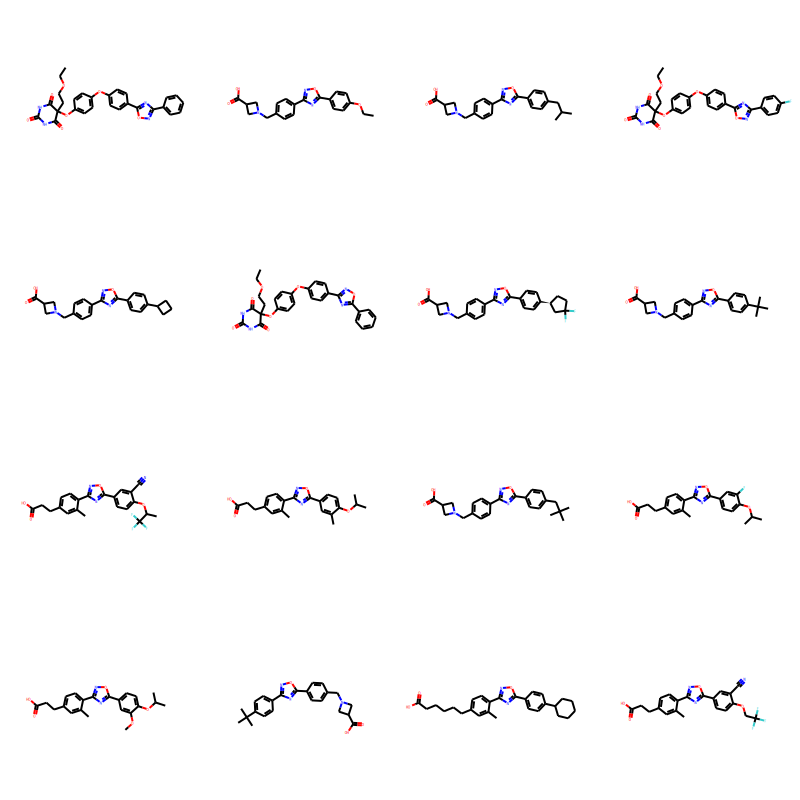

In [3]:
Draw.MolsToGridImage(mols[:16],molsPerRow=4)

This section takes advantages of bug fixes in the more recent patch release.
Note that as of this writing (corresponding to the 2019.03.4 patch release), the first and second parts of this notebook don't both work properly with a single RDKit version.

In [5]:
print(rdkit.__version__)

2019.03.4


,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,

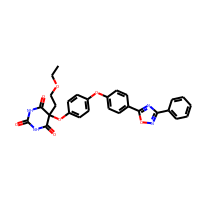
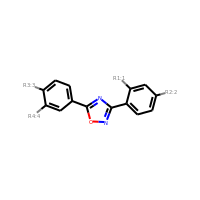
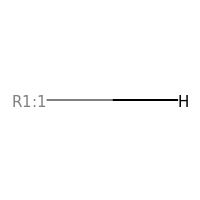
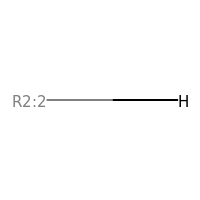
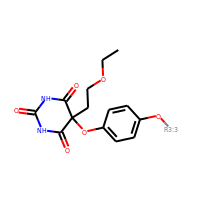
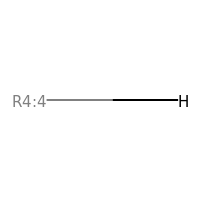
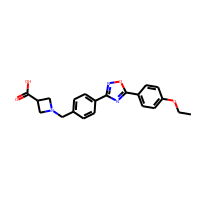
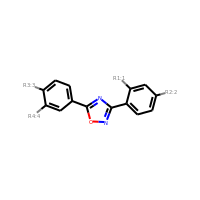
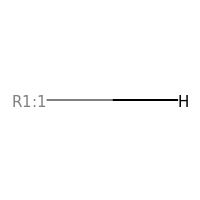
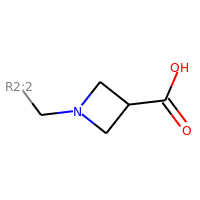
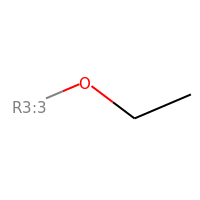
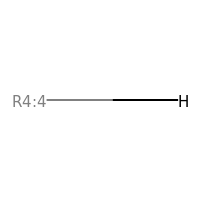
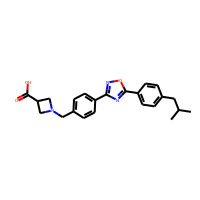
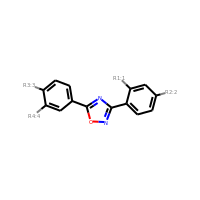
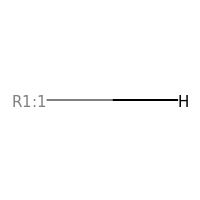
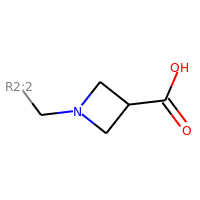
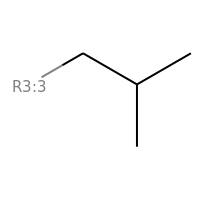
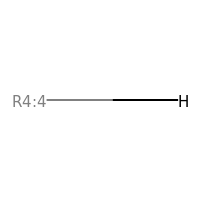
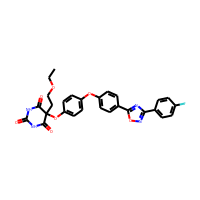
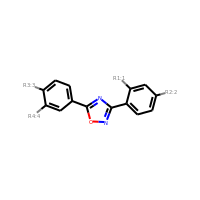
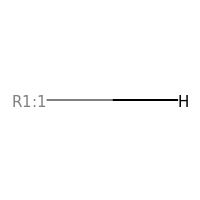
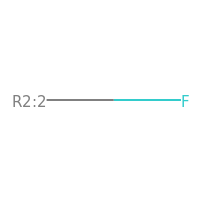
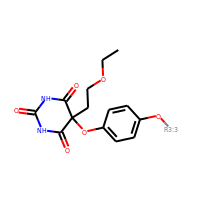
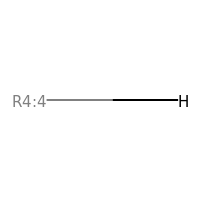
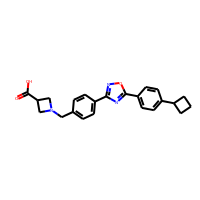
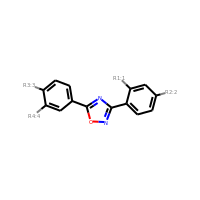
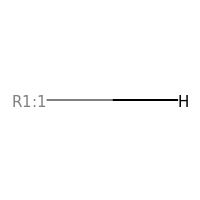
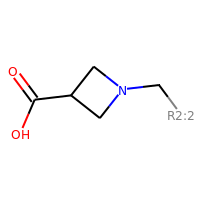
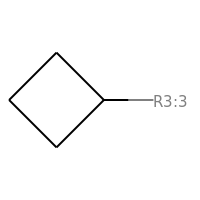
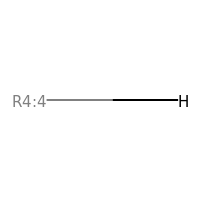
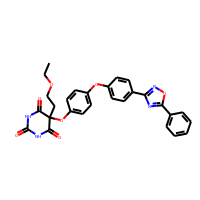
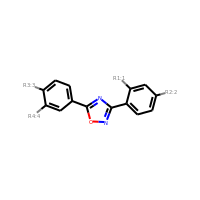
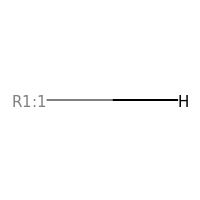
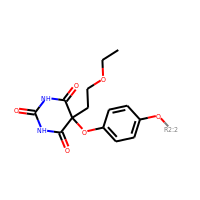
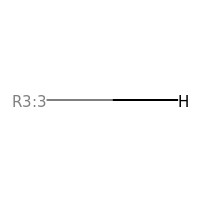
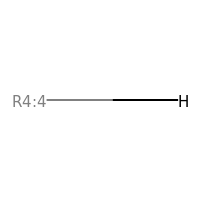
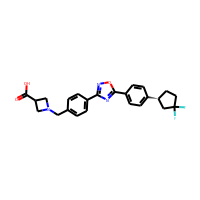
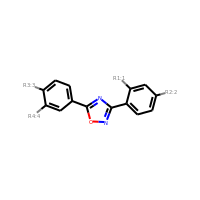
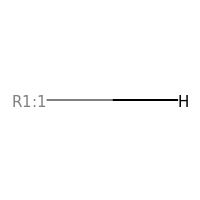
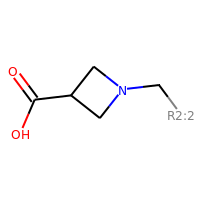
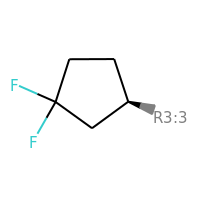
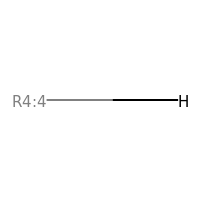
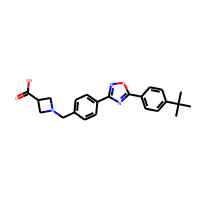
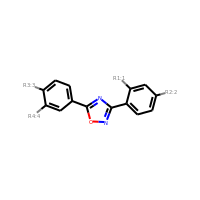
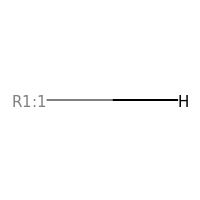
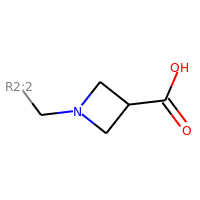
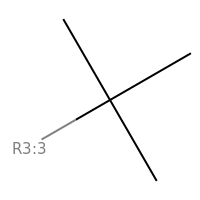
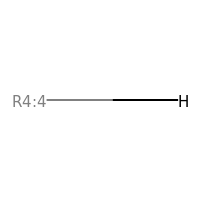
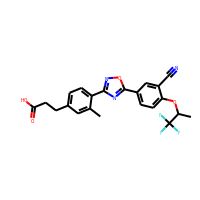
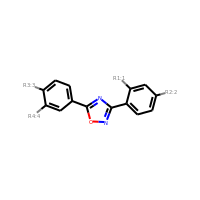
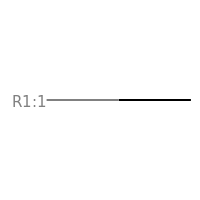
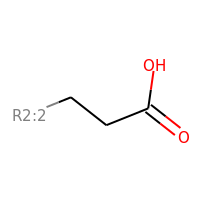
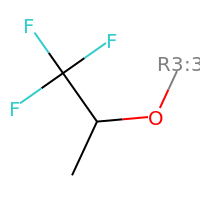
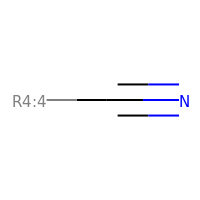
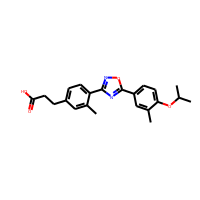
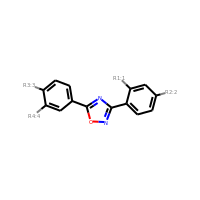
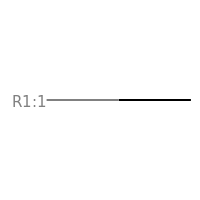
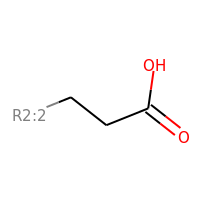
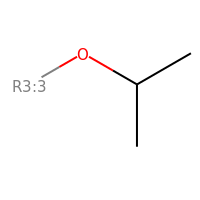
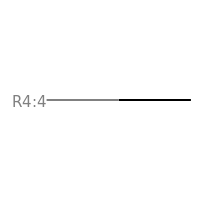
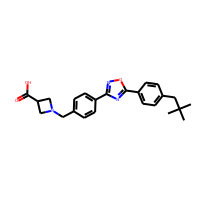
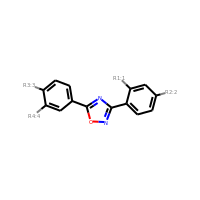
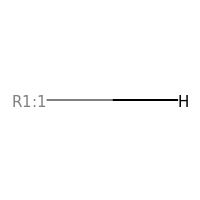
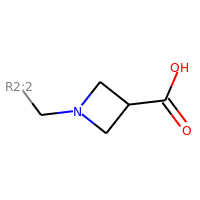
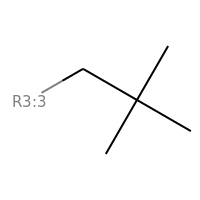
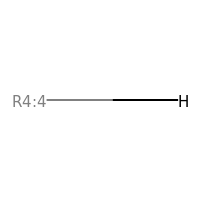
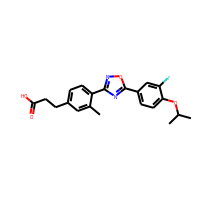
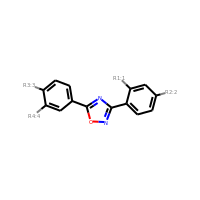
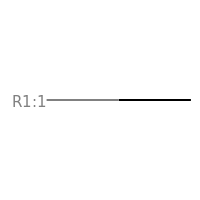
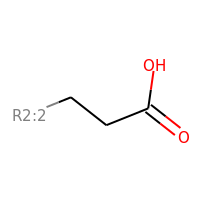
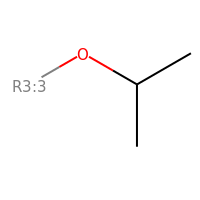
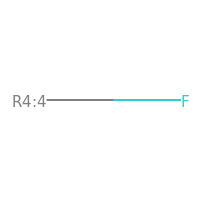
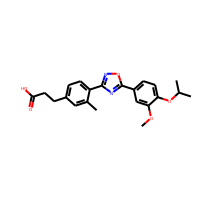
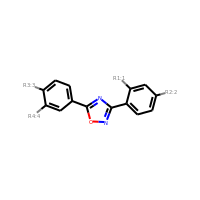
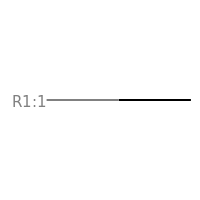
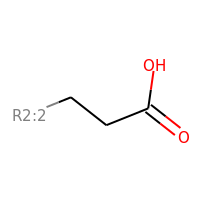
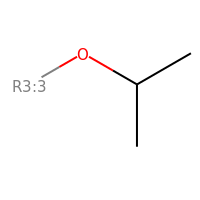
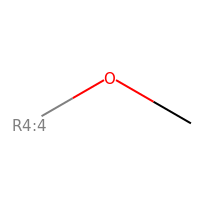
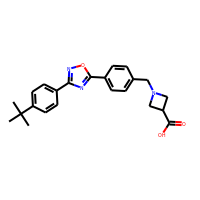
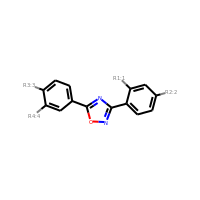
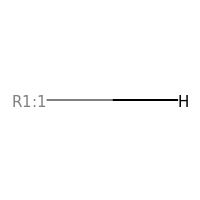
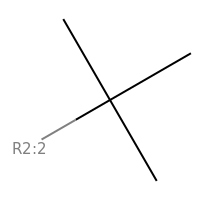
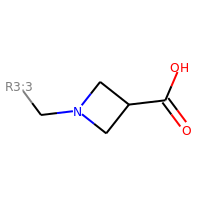
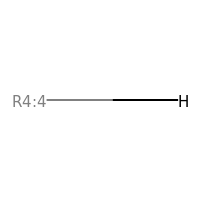
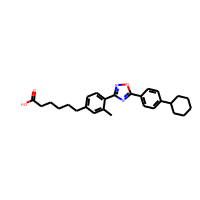
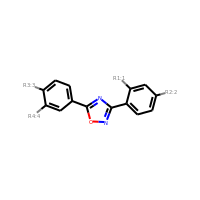
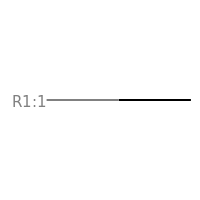
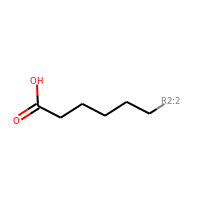
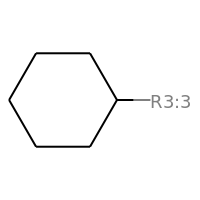
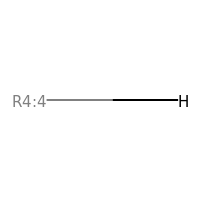
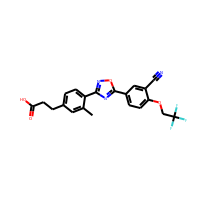
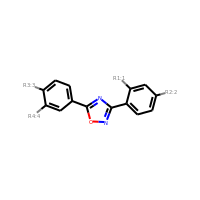
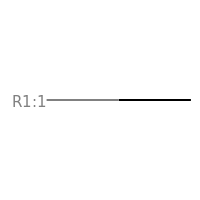
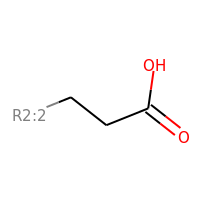
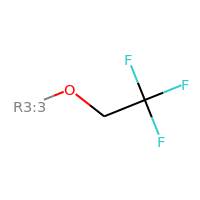
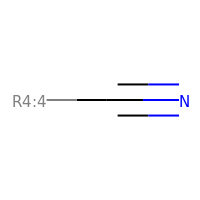

In [10]:
m16 = mols[:16]
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([core],m16,asSmiles=False,asRows=False)
groups_to_df(groups,m16,include_core=True,redraw_sidechains=True)

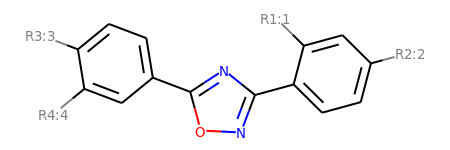

In [11]:
groups['Core'][0]

Let's do a query with labelled R groups:

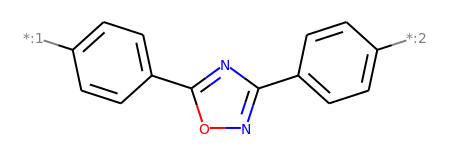

In [12]:
lcore = Chem.MolFromSmiles('c1cc([*:1])ccc1-c2nc(c1ccc([*:2])cc1)no2')
lcore

,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,

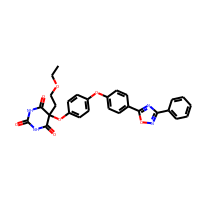
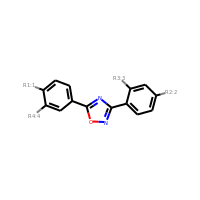
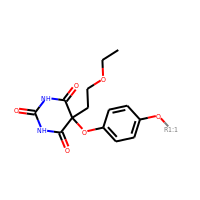
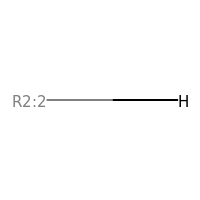
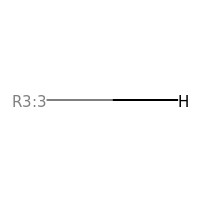
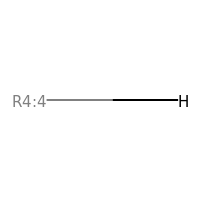
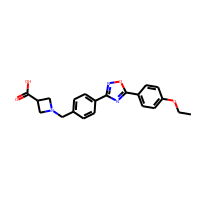
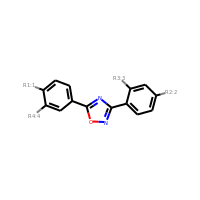
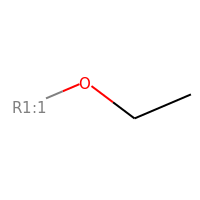
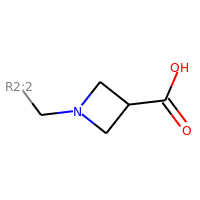
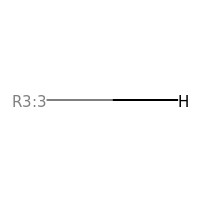
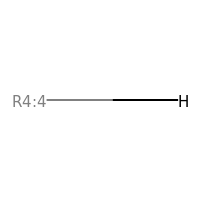
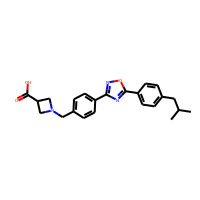
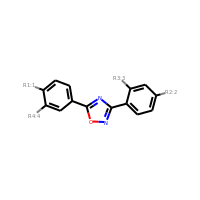
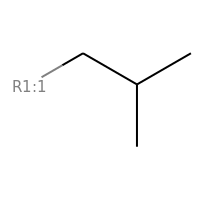
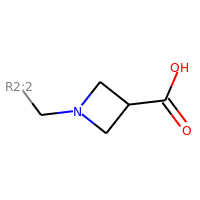
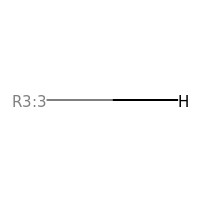
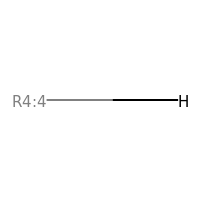
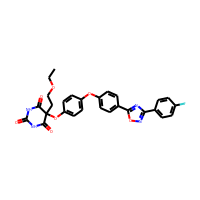
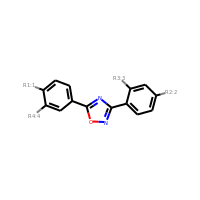
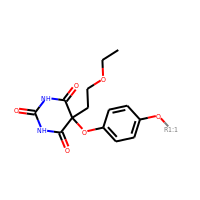
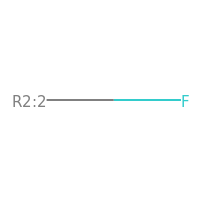
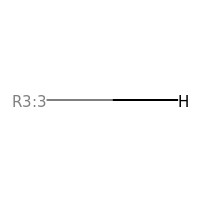
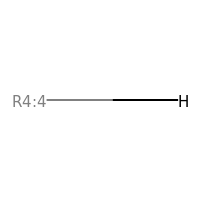
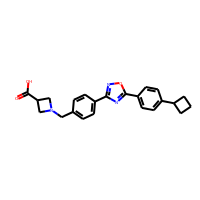
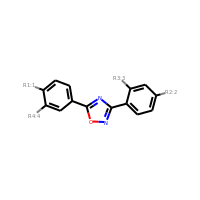
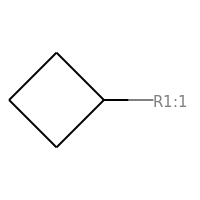
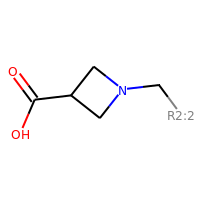
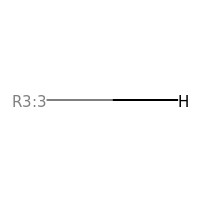
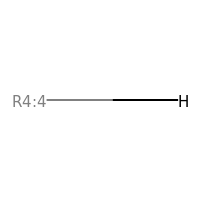
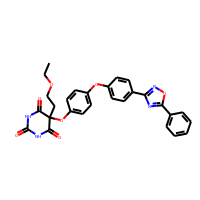
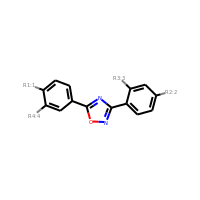
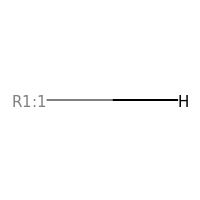
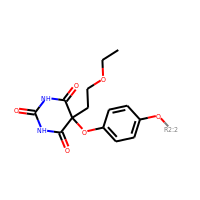
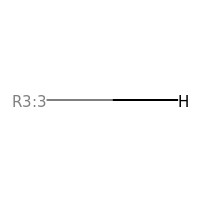
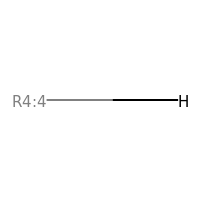
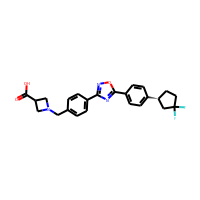
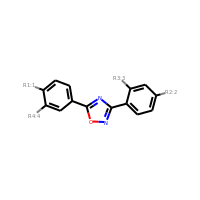
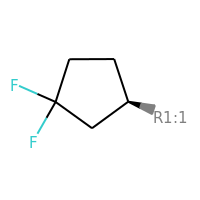
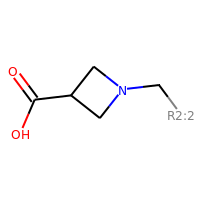
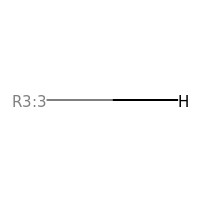
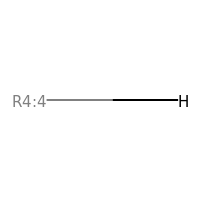
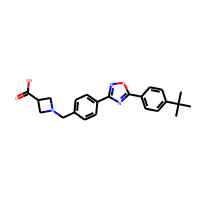
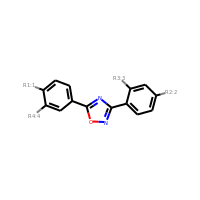
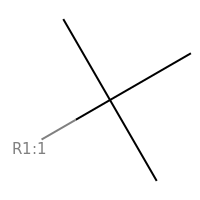
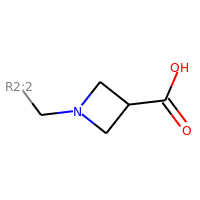
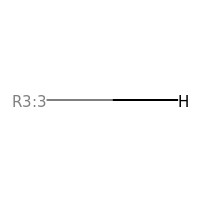
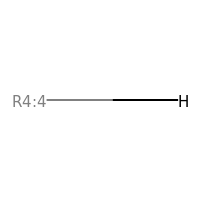
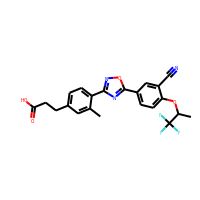
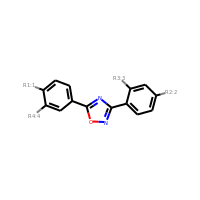
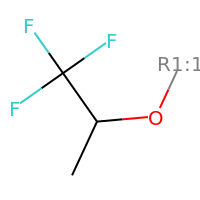
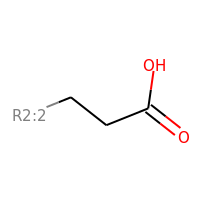
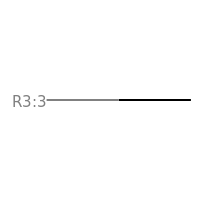
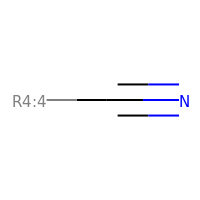
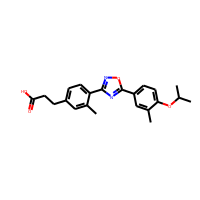
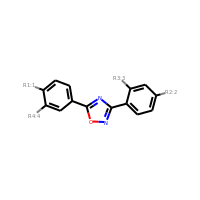
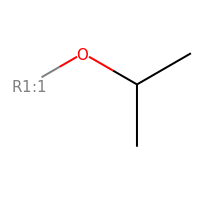
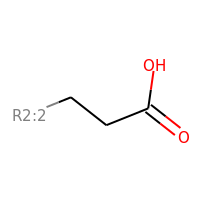
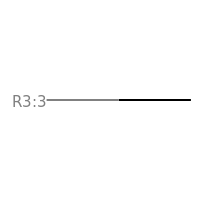
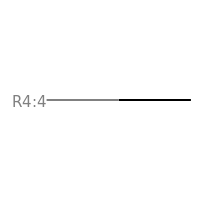
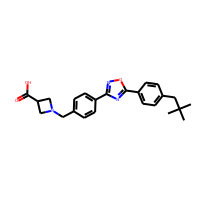
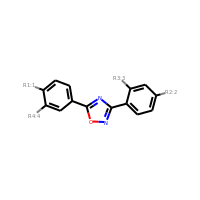
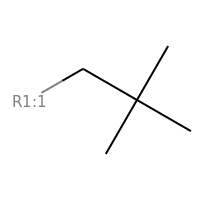
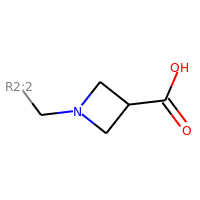
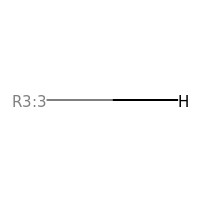
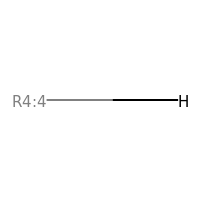
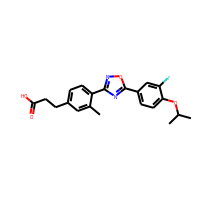
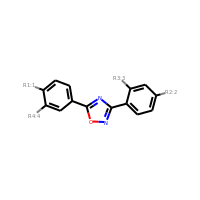
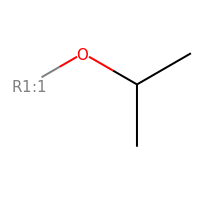
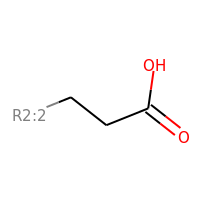
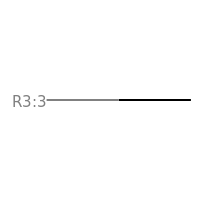
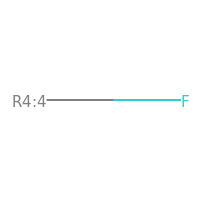
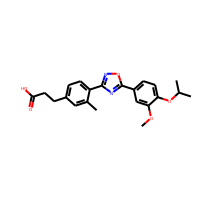
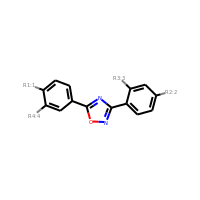
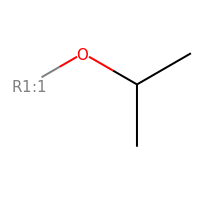
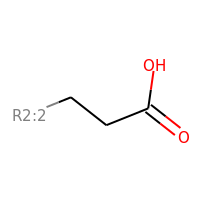
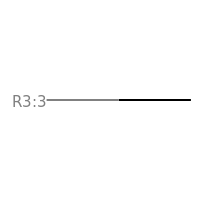
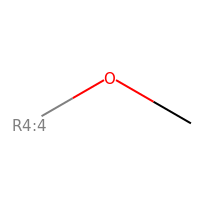
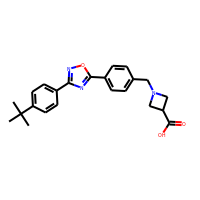
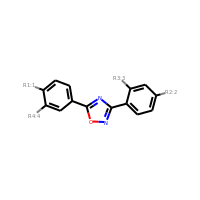
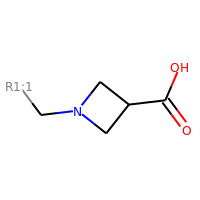
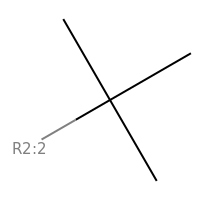
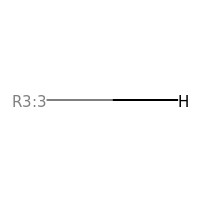
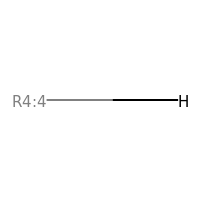
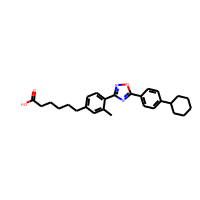
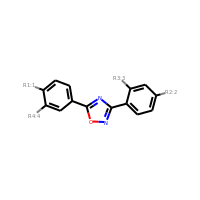
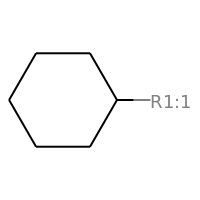
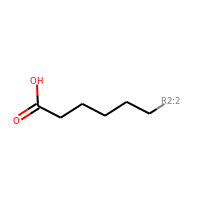
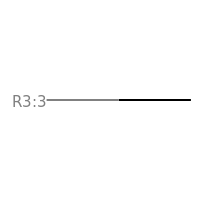
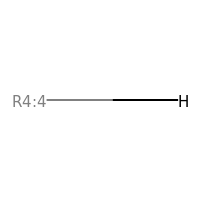
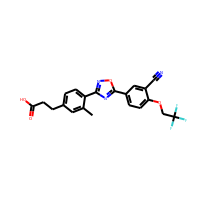
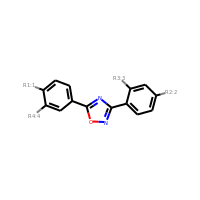
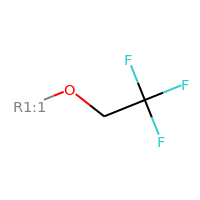
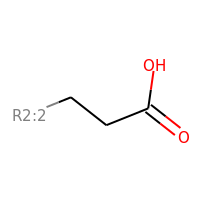
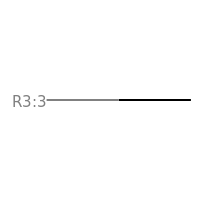
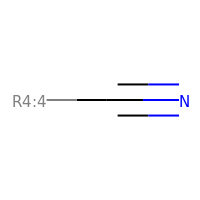

In [13]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([lcore],m16,asSmiles=False,asRows=False)
groups_to_df(groups,m16,include_core=True,redraw_sidechains=True)

We can exclude any molecules that have R groups in non-labelled positions:

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,
6,,,,
7,,,,
8,,,,
9,,,,

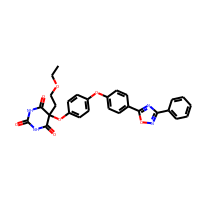
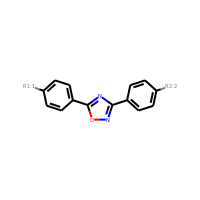
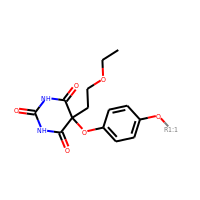
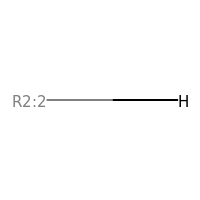
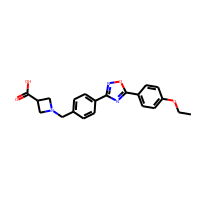
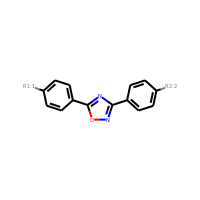
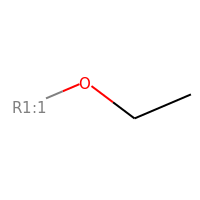
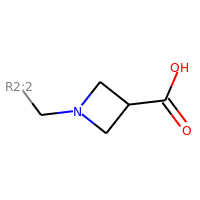
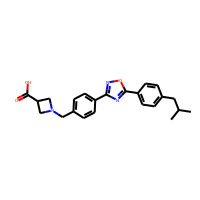
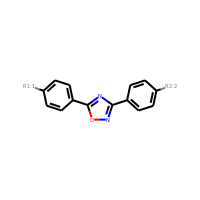
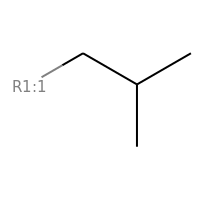
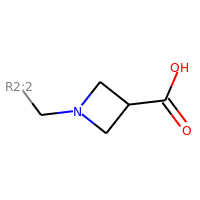
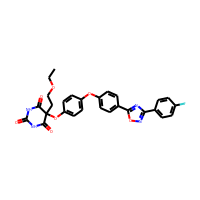
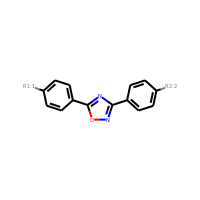
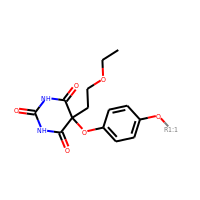
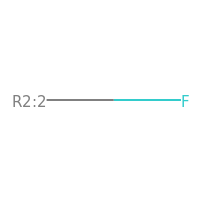
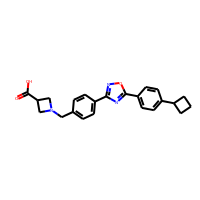
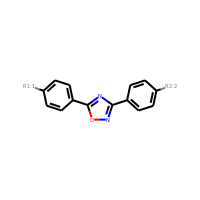
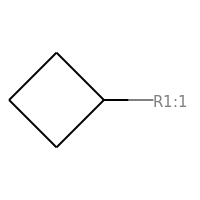
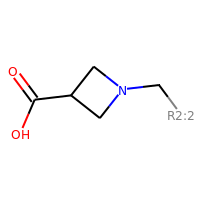
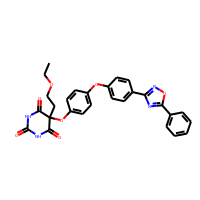
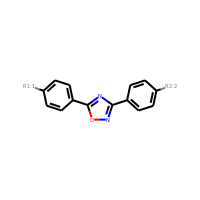
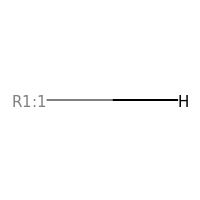
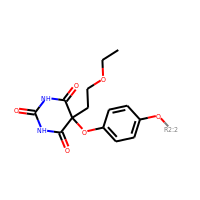
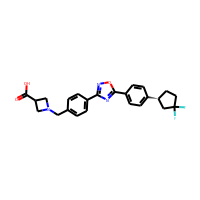
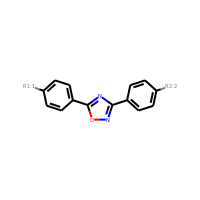
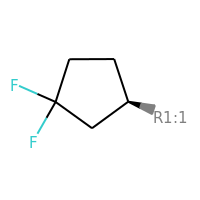
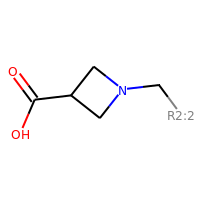
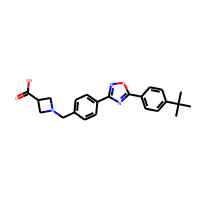
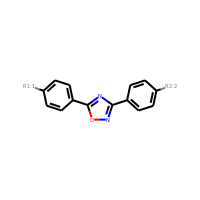
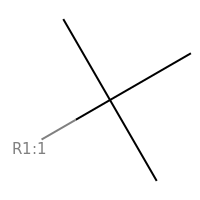
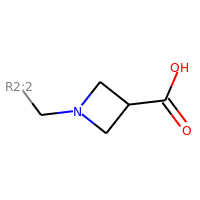
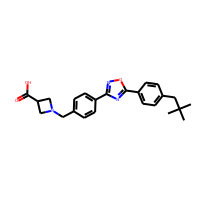
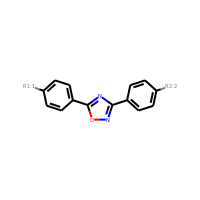
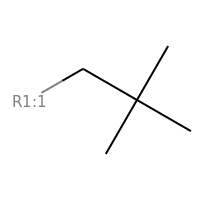
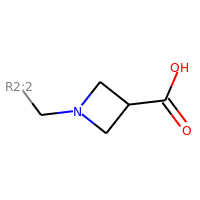
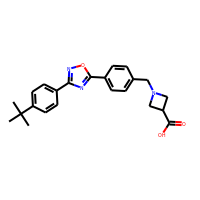
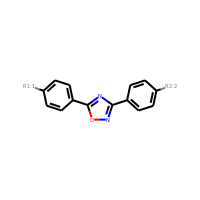
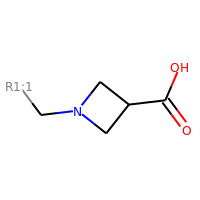
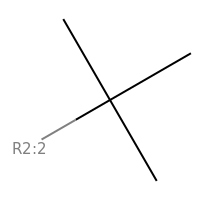

In [16]:
params = rdRGroupDecomposition.RGroupDecompositionParameters()
params.onlyMatchAtRGroups = True
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([lcore],m16,asSmiles=False,asRows=False,options=params)
tmols = [x for i,x in enumerate(m16) if i not in unmatched]
groups_to_df(groups,tmols,include_core=True,redraw_sidechains=True)

Let's look at the raw output:

In [18]:
params = rdRGroupDecomposition.RGroupDecompositionParameters()
params.onlyMatchAtRGroups = True
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([lcore],m16,asSmiles=True,asRows=False,options=params)
groups

{'Core': ['c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1'],
 'R1': ['[H]c1c([H])c(O[*:1])c([H])c([H])c1OC1(C([H])([H])C([H])([H])OC([H])([H])C([H])([H])[H])C(=O)N([H])C(=O)N([H])C1=O',
  '[H]C([H])([H])C([H])([H])O[*:1]',
  '[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[*:1]',
  '[H]c1c([H])c(O[*:1])c([H])c([H])c1OC1(C([H])([H])C([H])([H])OC([H])([H])C([H])([H])[H])C(=O)N([H])C(=O)N([H])C1=O',
  '[H]C1([H])C([H])([H])C([H])([*:1])C1([H])[H]',
  '[H][*:1]',
  '[H]C1([H])C(F)(F)C([H])([H])[C@]([H])([*:1])C1([H])[H]',
  '[H]C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])[*:1]',


The hydrogens are added for technical reasons, but we can remove them:

In [19]:
params = rdRGroupDecomposition.RGroupDecompositionParameters()
params.onlyMatchAtRGroups = True
params.removeHydrogensPostMatch = True
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([lcore],m16,asSmiles=True,asRows=False,options=params)
groups

{'Core': ['c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1',
  'c1cc([*:2])ccc1-c1noc(-c2ccc([*:1])cc2)n1'],
 'R1': ['CCOCCC1(Oc2ccc(O[*:1])cc2)C(=O)NC(=O)NC1=O',
  'CCO[*:1]',
  'CC(C)C[*:1]',
  'CCOCCC1(Oc2ccc(O[*:1])cc2)C(=O)NC(=O)NC1=O',
  'C1CC([*:1])C1',
  '[H][*:1]',
  'FC1(F)CC[C@@H]([*:1])C1',
  'CC(C)(C)[*:1]',
  'CC(C)(C)C[*:1]',
  'O=C(O)C1CN(C[*:1])C1'],
 'R2': ['[H][*:2]',
  'O=C(O)C1CN(C[*:2])C1',
  'O=C(O)C1CN(C[*:2])C1',
  'F[*:2]',
  'O=C(O)C1CN(C[*:2])C1',
  'CCOCCC1(Oc2ccc(O[*:2])cc2)C(=O)NC(=O)NC1=O',
  'O=C(O)C1CN(C[*:2])C1',
  'O=C(O)C1CN(C[*:2])C1',
  'O=C(O)C1CN(C[*:2])C1',
  'CC(C)(C)[*:2]']}